# Speech Emotion Recognition with SVM/CNN

In [1]:
import re
from keras import Sequential
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import  seaborn as sns
import librosa
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
import joblib
from sklearn.utils import shuffle

# Data Extraction

In [2]:
# CREATE DIRECTORY OF AUDIO FILES
Ravdess_Path = 'C:/Users/tahar/Documents/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/'
Crema_Path='C:/Users/tahar/Documents/speech-emotion-recognition-en/Crema/'
Savee_Path='C:/Users/tahar/Documents/speech-emotion-recognition-en/Savee/'
Tess_Path='C:/Users/tahar/Documents/speech-emotion-recognition-en/Tess/'

In [3]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
data = {'emotion' : [],
        'path' : []
        }
actor_folders = os.listdir(Ravdess_Path) #list files in audio directory
# Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:
for i in actor_folders:
    filename = os.listdir(Ravdess_Path + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        emotion = int(f.split('.')[0].split('-')[2])
        data['emotion'].append(emotion)
        # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
        data['path'].append(Ravdess_Path + i + '/' + f)

In [4]:
files = os.listdir(Crema_Path)
for f in files: # go through files in Crema folder
    emotion = f.split('.')[0].split('_')[2]
    if emotion=='SAD':
        data['emotion'].append('sad')
    elif emotion=='ANG':
        data['emotion'].append('angry')
    elif emotion=='DIS':
        data['emotion'].append('disgust')
    elif emotion=='FEA':
        data['emotion'].append('fear')
    elif emotion=='HAP':
        data['emotion'].append('happy')
    elif emotion=='NEU':
        data['emotion'].append('neutral')
    data['path'].append(Crema_Path + f)

In [5]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
oaf_yaf_folders = os.listdir(Tess_Path)
for i in oaf_yaf_folders:
    files = os.listdir(Tess_Path + i)
    for f in files:
        emotion = f.split('.')[0].split('_')[2]
        if emotion=='ps':
            data['emotion'].append('surprise')
        else:
            data['emotion'].append(emotion)
        # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
        data['path'].append(Tess_Path + i + '/' + f)

In [6]:
files = os.listdir(Savee_Path)
for f in files: # go through files in Crema folder
    emotion = f.split('.')[0].split('_')[1]
    emotion = re.sub('[0-9]','',emotion)
    if emotion=='a':
        data['emotion'].append('angry')
    elif emotion=='d':
        data['emotion'].append('disgust')
    elif emotion=='f':
        data['emotion'].append('fear')
    elif emotion=='h':
        data['emotion'].append('happy')
    elif emotion=='n':
        data['emotion'].append('neutral')
    elif emotion=='sa':
        data['emotion'].append('sad')
    elif emotion=='su':
        data['emotion'].append('surprise')
    data['path'].append(Savee_Path + f)

In [7]:
df = pd.DataFrame(data)
df['emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
df.head()

,emotion,path
0,neutral,C:/Users/tahar/Documents/speech-emotion-recogn...
1,neutral,C:/Users/tahar/Documents/speech-emotion-recogn...
2,neutral,C:/Users/tahar/Documents/speech-emotion-recogn...
3,neutral,C:/Users/tahar/Documents/speech-emotion-recogn...
4,neutral,C:/Users/tahar/Documents/speech-emotion-recogn...


In [8]:
df['emotion'].unique()

array(['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise'],
      dtype=object)

In [9]:
df.shape

(12162, 2)

# Data Augmentation

In [10]:
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def shifting(data,rate=1000):
    augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
    augmented_data=np.roll(data,augmented_data)
    return augmented_data

def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data,sr=sr,n_steps=pitch_factor)

def streching(data,rate=0.8):
    return librosa.effects.time_stretch(y=data,rate=rate)

# Feature extraction

In [11]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)

    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitching(data,sr,random=True)
    pitched_noised_audio=add_noise(pitched_audio1,random=True)
    aud4=extract_features(pitched_noised_audio,sr)
    audio=np.vstack((audio,aud4))

    return audio

In [12]:
X,Y=[],[]
for index,row in df.iterrows():
    features=get_features(row['path'])
    for i in features:
        X.append(i)
        Y.append(row['emotion'])

In [13]:
processed_audios_df=pd.DataFrame(X)
processed_audios_df['Emotion']=Y
processed_audios_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518,neutral
1,0.243652,0.372070,0.489258,0.497070,0.500977,0.504395,0.502441,0.488770,0.493164,0.486328,...,-4.932448,-1.702202,-1.803251,-6.853596,-2.475780,6.203646,0.991019,-2.911816,-2.650631,neutral
2,0.264648,0.361328,0.468262,0.407715,0.371094,0.353027,0.346191,0.407715,0.463867,0.533203,...,0.174467,0.171601,0.168493,0.165162,0.161605,0.157850,0.153842,0.149646,0.145245,neutral
3,0.254395,0.380371,0.516602,0.506348,0.515137,0.517578,0.506836,0.509277,0.498047,0.500488,...,4.484966,-1.062807,-2.106036,-3.013501,4.970066,0.512814,-1.569251,-0.242193,-0.189812,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
5,0.259766,0.388672,0.510254,0.503418,0.495605,0.494629,0.499512,0.496582,0.501465,0.495117,...,2.711888,-0.406655,-4.457390,-4.177866,-2.269811,0.470799,2.387503,1.531126,1.407382,neutral
6,0.216309,0.293457,0.357422,0.329102,0.321289,0.347168,0.400391,0.434570,0.438965,0.423340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
7,0.248047,0.356934,0.457520,0.467773,0.451660,0.463867,0.477051,0.480469,0.459961,0.427246,...,0.562835,0.059065,-0.114015,-0.413559,-0.155140,0.521128,0.505862,-0.357632,-0.846701,neutral
8,0.183105,0.376953,0.551270,0.642090,0.800781,0.777832,0.801270,0.789551,0.794922,0.850098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
9,0.245605,0.368164,0.492188,0.490234,0.498535,0.492188,0.498047,0.501953,0.489258,0.490234,...,-0.377227,-3.642253,1.098809,6.598364,2.503599,5.139227,4.837533,0.395868,-6.032766,neutral


In [14]:
# EXPORT TO CSV
processed_audios_df.to_csv('audio.csv', index=False)

In [15]:
df=pd.read_csv('audio.csv')
df.shape

(48648, 2377)

In [16]:
df=df.fillna(0)
print(df.isna().sum())
df.shape

0          0
1          0
2          0
3          0
4          0
          ..
2372       0
2373       0
2374       0
2375       0
Emotion    0
Length: 2377, dtype: int64


(48648, 2377)

In [17]:
# check if dataset is balanced
Counter(df.loc[:,'Emotion'])

Counter({'happy': 7692,
         'sad': 7692,
         'angry': 7692,
         'fear': 7692,
         'disgust': 7692,
         'neutral': 7580,
         'surprise': 2608})

In [18]:
x= df.drop('Emotion', axis=1)
y=df.loc[ : ,'Emotion']
lb= LabelEncoder()
y_encoded = lb.fit_transform(y)
joblib.dump(lb,'label_encoder.pkl')

['label_encoder.pkl']

In [19]:
smote = SMOTE(sampling_strategy='minority') # use smote technique to bump up our minority class in this case surprise class
X1, y = smote.fit_resample(x,y_encoded)
Standard_Scaler=StandardScaler()
X=Standard_Scaler.fit_transform(X1) # scale our features
joblib.dump(Standard_Scaler,'scaler.pkl')
Counter(y) # check again if our dataset get balanced

Counter({3: 7692, 5: 7692, 0: 7692, 2: 7692, 1: 7692, 6: 7692, 4: 7580})

# Training models and comparing their performances

In [20]:
# split data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((42985, 2376), (10747, 2376), (42985,), (10747,))

In [21]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,test_size=0.1,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape

((38686, 2376), (10747, 2376), (4299, 2376), (38686,), (10747,), (4299,))

In [22]:
# Create an SVM classifier
svm = SVC(C=10,gamma='auto')
'''
# Define  hyperparameters grid for the search
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [1, 10],
              'gamma': ['scale', 'auto']}

# Create a GridSearchCV object with 5-fold cross-validation to search for the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=5)
# Apply the grid search on our data
grid_search.fit(x,y)
# Redefine the SVM classifier with the parameters obtained from the grid search
k=grid_search.best_params_['kernel']
g=grid_search.best_params_['gamma']
c=grid_search.best_params_['C']
svm = SVC(kernel=k,gamma=g,C=c)
'''
# Apply SVM on the data
svm.fit(X_train,y_train)

SVC(C=10, gamma='auto')

In [23]:
y_pred = svm.predict(X_test)
accuracy= accuracy_score(y_test,y_pred )
accuracy

0.8379082534660836

In [24]:
# PREDICTIONS
predictions = lb.inverse_transform(y_pred)
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual = lb.inverse_transform(y_test)
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
final_df = actual.join(predictions)
final_df[140:150]

,Actual Values,Predicted Values
140,surprise,surprise
141,disgust,disgust
142,neutral,sad
143,fear,fear
144,angry,happy
145,fear,happy
146,angry,angry
147,disgust,disgust
148,sad,sad
149,surprise,surprise


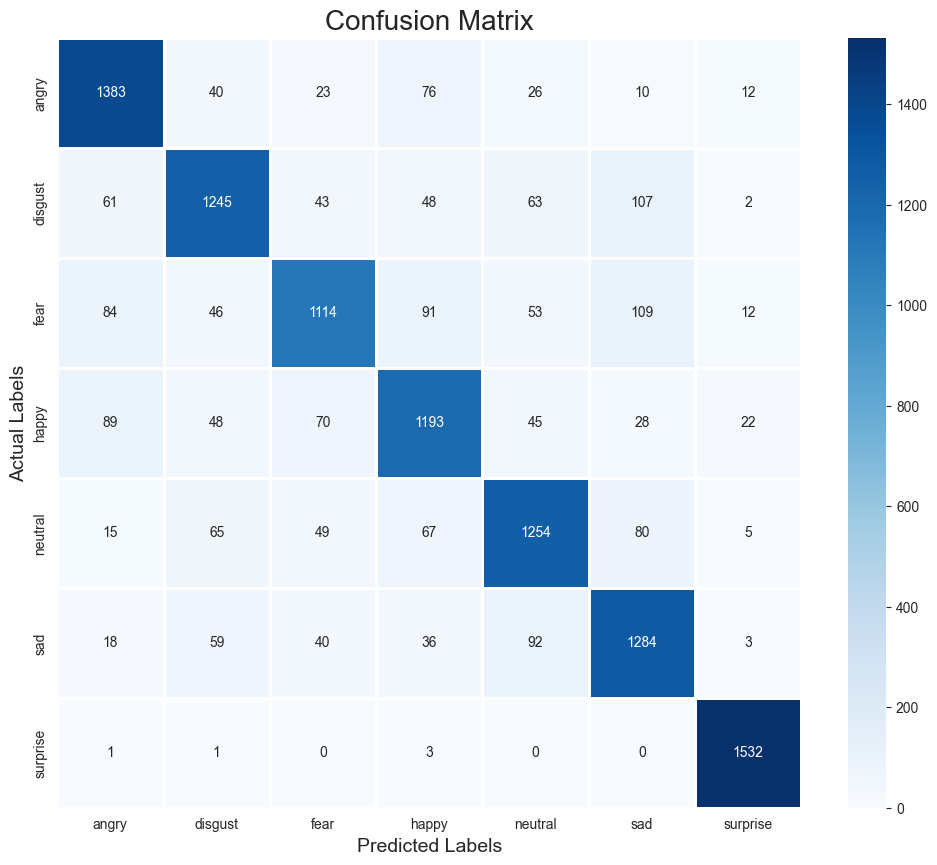

In [25]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in  lb.classes_ ] , columns = [i for i in lb.classes_ ])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [26]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [27]:
from keras.regularizers import l2
# Define a CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 64)          256       
                                                                 
 conv1d_1 (Conv1D)           (None, 2376, 64)          12352     
                                                                 
 batch_normalization (BatchN  (None, 2376, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1188, 64)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1188, 128)         2

In [28]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
# Train the model
model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=64, epochs=50)

Epoch 1/50
142/605 [======>.......................] - ETA: 7:31 - loss: 3.2460 - accuracy: 0.1679

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
eval_model = model.evaluate(X_test, y_test)
eval_model # got lower accuracy score than svm

In [ ]:
# PREDICTIONS
y_pred = model.predict(X_test)
y_pred=y_pred.argmax(axis=1)
predictions = y_pred.astype(int).flatten()
predictions = lb.inverse_transform(predictions)
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test
actual = lb.inverse_transform(actual)
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH
final_df = actual.join(predictions)
final_df[140:150]

In [ ]:
# CREATE CONFUSION MATRIX OF ACTUAL VS PREDICTION
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in  lb.classes_ ] , columns = [i for i in lb.classes_ ])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Plot learning curve for both SVM and CNN models

In [ ]:
# display learning curve for SVM and CNN models
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)
train_sizes = np.linspace(0.1, 1.0, 5)
cnn_train_scores = []
cnn_test_scores = []
svm_train_scores = []
svm_test_scores = []
train_sizes = [ int(train_size * len(X_train)) for train_size in train_sizes]

for train_size in train_sizes:
  X_train_subset = X_train[:train_size]
  y_train_subset = Y_train_encoded[:train_size]
  model.fit(X_train, Y_train_encoded, validation_data=(X_test, Y_test_encoded), batch_size=34, epochs=75, verbose=0)
  train_score = model.evaluate(X_train_subset, y_train_subset, verbose=0)[1]
  test_score = model.evaluate(X_test, Y_test_encoded, verbose=0)[1]
  cnn_train_scores.append(train_score)
  cnn_test_scores.append(test_score)

for train_size in train_sizes:
  X_train_subset = X_train[:train_size]
  y_train_subset = Y_train[:train_size]
  svm.fit(X_train_subset, y_train_subset)
  y_train_pred = svm.predict(X_train_subset)
  y_test_pred = svm.predict(X_test)
  train_score = accuracy_score(y_train_subset,y_train_pred)
  test_score = accuracy_score(Y_test, y_test_pred)
  svm_train_scores.append(train_score)
  svm_test_scores.append(test_score)

ax[0].plot(train_sizes, cnn_train_scores, 'o-', label='Training Score')
ax[0].plot(train_sizes, cnn_test_scores, 'o-', label='Validation Score')
ax[0].set_xlabel('Training Examples')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Learning Curve for CNN Classifier')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(train_sizes, svm_train_scores, 'o-', label='Training Score')
ax[1].plot(train_sizes, svm_test_scores, 'o-', label='Validation Score')
ax[1].set_xlabel('Training Examples')
ax[1].set_title('Learning Curve for SVM Classifier')
ax[1].legend()
ax[1].grid(True)